# DirectQuery: Combining Atoti and Data Warehouses

We know Atoti provides in-memory analytics for big data. This means that we hold data in memory and perform aggregation on the fly in order to achieve fast and dynamic computations. In our usual Atoti setup, the hosting server requires a memory size that's about 1.5 times of the amount of data that gets loaded into the cube.    

With Atoti's DirectQuery, we can better support our users who store their data on the cloud! In fact, it applies for on-premise databases such as [ClickHouse](https://clickhouse.com/clickhouse) and [Microsoft SQL Server](https://www.microsoft.com/en-sg/sql-server/sql-server-downloads) too.  
In a gist, here's what DirectQuery offers:  

<img src="https://data.atoti.io/notebooks/direct-query/img/cost_vs_performance.png" width="850px"/>

- Scalability

> Leveraging the scalability of cloud data warehouse, the server that hosts Atoti only has to take into consideration the amount of data that gets queried on a daily basis.  
> Instead of storing all of the data in physical memory, DirectQuery enables us to query the Cloud database directly, reducing the need for memory in the hosting server.  

- Cost savings

> Other than saving on the memory required for the hosting server, DirectQuery helps to save on the data transfer costs.  
> While cloud data warehouse is cost-effective, we incur costs when we perform queries.  
> We can reduce querying to the Cloud database by loading an aggregated cache in memory for the most frequently queried data.  

- Technology agnosticism

> With changes to only a few lines of data connectivity code in Atoti, we can easily switch from one Cloud service provider to another without impacting the Atoti server.  
> We can even switch over to other data connectors such as physical files.  


This notebook provides a quick introduction to how we can connect to Google BigQuery and create an Atoti cube.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=intro-direct-query" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

## Google BigQuery configuration

### Step 1 - Create role with permissions

- Login to Google Cloud console.
- Navigate to __IAM & Admin__ > __Roles__.  

Create a role with the following permission for the DirectQuery users:  

- bigquery.datasets.get
- bigquery.jobs.create
- bigquery.readsessions.create
- bigquery.readsessions.getData
- bigquery.readsessions.update
- bigquery.routines.get
- bigquery.tables.get
- bigquery.tables.getData
- bigquery.tables.list

<img src="https://data.atoti.io/notebooks/direct-query/img/bigquery_permission.png" />

For more details, refer to the [Atoti Server documentation](https://docs.activeviam.com/products/atoti/server/latest/docs/directquery/connect_to_external/connect_to_bigquery/).

### Step 2 - Create Service Account

- Under __IAM & Admin__, navigate to __Service Accounts__.  
- Create service account and assign the role created in Step 1.  

<img src="https://data.atoti.io/notebooks/direct-query/img/service_account.png" width="700px"/>  

### Step 3 - Generate API Key 

- Navigate to the __KEYS__ tab and generate a new key.  

<img src="https://data.atoti.io/notebooks/direct-query/img/create_key.png" />  

- Select "JSON" as key type and save the downloaded key to a server folder:  

<img src="https://data.atoti.io/notebooks/direct-query/img/json_key.png" />

- Configure environment variable pointing to the JSON key. In this use case, our environment variable is `DQ_GOOGLE_CREDENTIAL`:  

<img src="https://data.atoti.io/notebooks/direct-query/img/environment_variable.png" />  

Alternatively, we can set up [Application Default Credentials](https://cloud.google.com/docs/authentication/provide-credentials-adc) for authentication.  

## Database set up  

To try out this notebook, you can setup the database schema and tables using the [database script](db_schema.sql) in the use case folder.  

## Atoti Setup

We import [Atoti](https://docs.atoti.io/latest/getting_started/installation.html) library and create the [Atoti Session](https://docs.atoti.io/latest/lib/atoti/atoti.session.html#atoti.Session) as we always do.  

In [1]:
import os

import atoti as tt

In [2]:
session = tt.Session()

## DirectQuery Pre-requisite

DirectQuery supports a few [databases](https://docs.atoti.io/latest/reference.html#directquery). For each of these databases, we have to install its respective Python plugin.  
- `atoti-directquery-bigquery` : To use DirectQuery on Google BigQuery.
- `atoti-directquery-clickhouse` : To use DirectQuery with ClickHouse.
- `atoti-directquery-databricks` : To use DirectQuery on Databricks.
- `atoti-directquery-mssql` : To use DirectQuery with Microsoft SQL Server.
- `atoti-directquery-redshift` : To use DirectQuery on Amazon Redshift.
- `atoti-directquery-snowflake` : To use DirectQuery on Snowflake.
- `atoti-directquery-synapse` : To use DirectQuery on Azure Synapse Analytics.  

In our example, we install the plugin for Google BigQuery. Uncomment the below line to install the plugin if it isn't installed.  

⚠️We only support one type of database connection per Atoti session.

In [3]:
# ! pip install atoti-directquery-bigquery

We will be using two components from the DirectQueryPlugin:
- [BigqueryConnectionInfo](https://docs.atoti.io/latest/lib/atoti-directquery-bigquery/atoti_directquery_bigquery.connection_info.html): configure the connection information to BigQuery
- [BigqueryTableOptions](https://docs.atoti.io/latest/lib/atoti-directquery-bigquery/atoti_directquery_bigquery.table_options.html): configure the table options about the external table to create in Atoti  

⚠️Use the corresponding components for different databases if we are using a different one from BigQuery. E.g. we use [`ClickhouseConnectionInfo`](https://docs.atoti.io/latest/lib/atoti-directquery-clickhouse/atoti_directquery_clickhouse.connection_info.html) and [`ClickhouseTableOptions`](https://docs.atoti.io/latest/lib/atoti-directquery-clickhouse/atoti_directquery_clickhouse.table_options.html) if we are connecting to [ClickHouse](https://clickhouse.com/).

## Connection setup to Google BigQuery

In [4]:
from atoti_directquery_bigquery import BigqueryConnectionInfo

In the below snippet, we use the environment variable to obtain the path to the [API key generated previous in Step 3](#Step-3---Generate-API-Key).  
Setting the credential path into `BigqueryConnectionInfo`, we can invoke the connection to the external database.  

In [5]:
credential = os.environ["DQ_GOOGLE_CREDENTIAL"]
connection_info = BigqueryConnectionInfo(credential)

external_database = session.connect_to_external_database(connection_info)

### Discover External Tables

Once connected, we can discover the tables available to us from the external database.

In [6]:
external_database.tables

ExternalTables(_tables={'adq-bq': {'tutorial': [t[('adq-bq', 'tutorial', 'PRODUCTS')], t[('adq-bq', 'tutorial', 'SALES')]]}}, _database_key='BIGQUERY', _create_table=<function ExternalDatabaseConnection.tables.<locals>.<lambda> at 0x134e323a0>)

If the database has many schemas, we can perform a filter to access only the schema that we want.

In [7]:
external_database.tables._filter(schema_pattern="tutorial")

ExternalTables(_tables={'adq-bq': {'tutorial': [t[('adq-bq', 'tutorial', 'PRODUCTS')], t[('adq-bq', 'tutorial', 'SALES')]]}}, _database_key='BIGQUERY', _create_table=<function ExternalDatabaseConnection.tables.<locals>.<lambda> at 0x134e32550>)

### Discover Table Columns

If a table name is unique in the database, we can check its structure directly using its name:  

In [8]:
external_database.tables["SALES"]

However, to be precise, it is a good practice to refer to the table using its database, schema and table names:

## Add External Table to Atoti

Since we have connected to the external database and we are able to see its structure, we can add the required tables to the Atoti session.  

Using [BigqueryTableOptions](https://docs.atoti.io/latest/lib/atoti-directquery-bigquery/atoti_directquery_bigquery.table_options.html#atoti_directquery_bigquery.BigqueryTableOptions), we can define additional options to the table that we will create in Atoti:
- keys: keys used to identify unique rows for updating of data
- clustering_columns: columns used for splitting up queries
- array_conversion: converting values spread over multiple columns into array columns 

We will only use `keys` and `clustering_columns` in our example.

In [9]:
from atoti_directquery_bigquery import BigqueryTableOptions

Similar to how we create keys for Atoti tables, we set the key columns in the `BigqueryTableOptions`. Note that this external table is created in Atoti and the defined keys affects only the data that is accessible in Atoti. It does not change the tables in BigQuery.  

To distinguish our Atoti external table from the BigQuery table, we named them differently in our example.  

In [10]:
sales_table = session.add_external_table(
    external_database.tables["SALES"],
    table_name="Atoti Sales",
    options=BigqueryTableOptions(
        keys=["SALE_ID"], clustering_columns=["DATE", "PRODUCT"]
    ),
)

To speed up querying, Atoti makes use of [aggregate providers](https://docs.atoti.io/latest/lib/atoti/atoti.aggregate_provider.html#atoti.AggregateProvider) to pre-aggregates some table columns up to certain levels.  
Feeding such providers from an external database can result in very large queries to be run on the database. Some databases can have trouble processing such large queries.  
Therefore, we define [clustering columns](https://docs.activeviam.com/products/atoti/server/latest/docs/directquery/directquery-clustering-fields/) to help split up queries made by DirectQuery to these external database when feeding the aggregate providers.  

The `clustering_columns` parameter allows us to define columns to be used for clustering. While our example uses a small dataset and clustering column is not necessary, we demonstrate how it can be used in the snippet above.  

In [11]:
sales_table.head()

,DATE,SHOP,PRODUCT,QUANTITY,UNIT_PRICE
SALE_ID,,,,,
S0009,2022-01-31,shop_3,BED_2,1,150.0
S0008,2022-01-31,shop_4,BED_2,1,150.0
S0007,2022-02-01,shop_5,BED_2,1,150.0
S0017,2022-02-04,shop_3,HOO_5,1,48.0
S0019,2022-02-02,shop_3,HOO_5,1,48.0


We can add multiple tables.

In [12]:
products_table = session.add_external_table(
    external_database.tables["PRODUCTS"],
    table_name="Atoti Product",
    options=BigqueryTableOptions(keys=["PRODUCT_ID"]),
)

products_table.head()

,CATEGORY,SUB_CATEGORY,SIZE,PURCHASE_PRICE,COLOR,BRAND
PRODUCT_ID,,,,,,
TSH_4,Cloth,Tshirt,L,20.0,black,Over
TSH_3,Cloth,Tshirt,M,19.0,brown,Over
HOO_5,Cloth,Hoodie,M,38.0,red,Mega
BED_2,Furniture,Bed,Single,127.0,red,Mega
TAB_0,Furniture,Table,1m80,190.0,black,Basic


Once we have created our external tables, the rest is _simply the usual stuff for Atoti_.

## Atoti Cube Setup

From this section onwards, the coding remains the same regardless of the underlying data source.  

As we have always done, we join the tables and create the cube.

In [13]:
sales_table.join(products_table, sales_table["PRODUCT"] == products_table["PRODUCT_ID"])

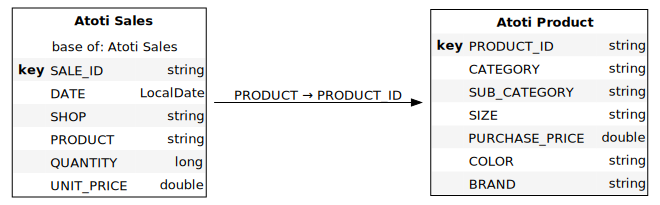

In [14]:
cube = session.create_cube(sales_table)
session.tables.schema

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
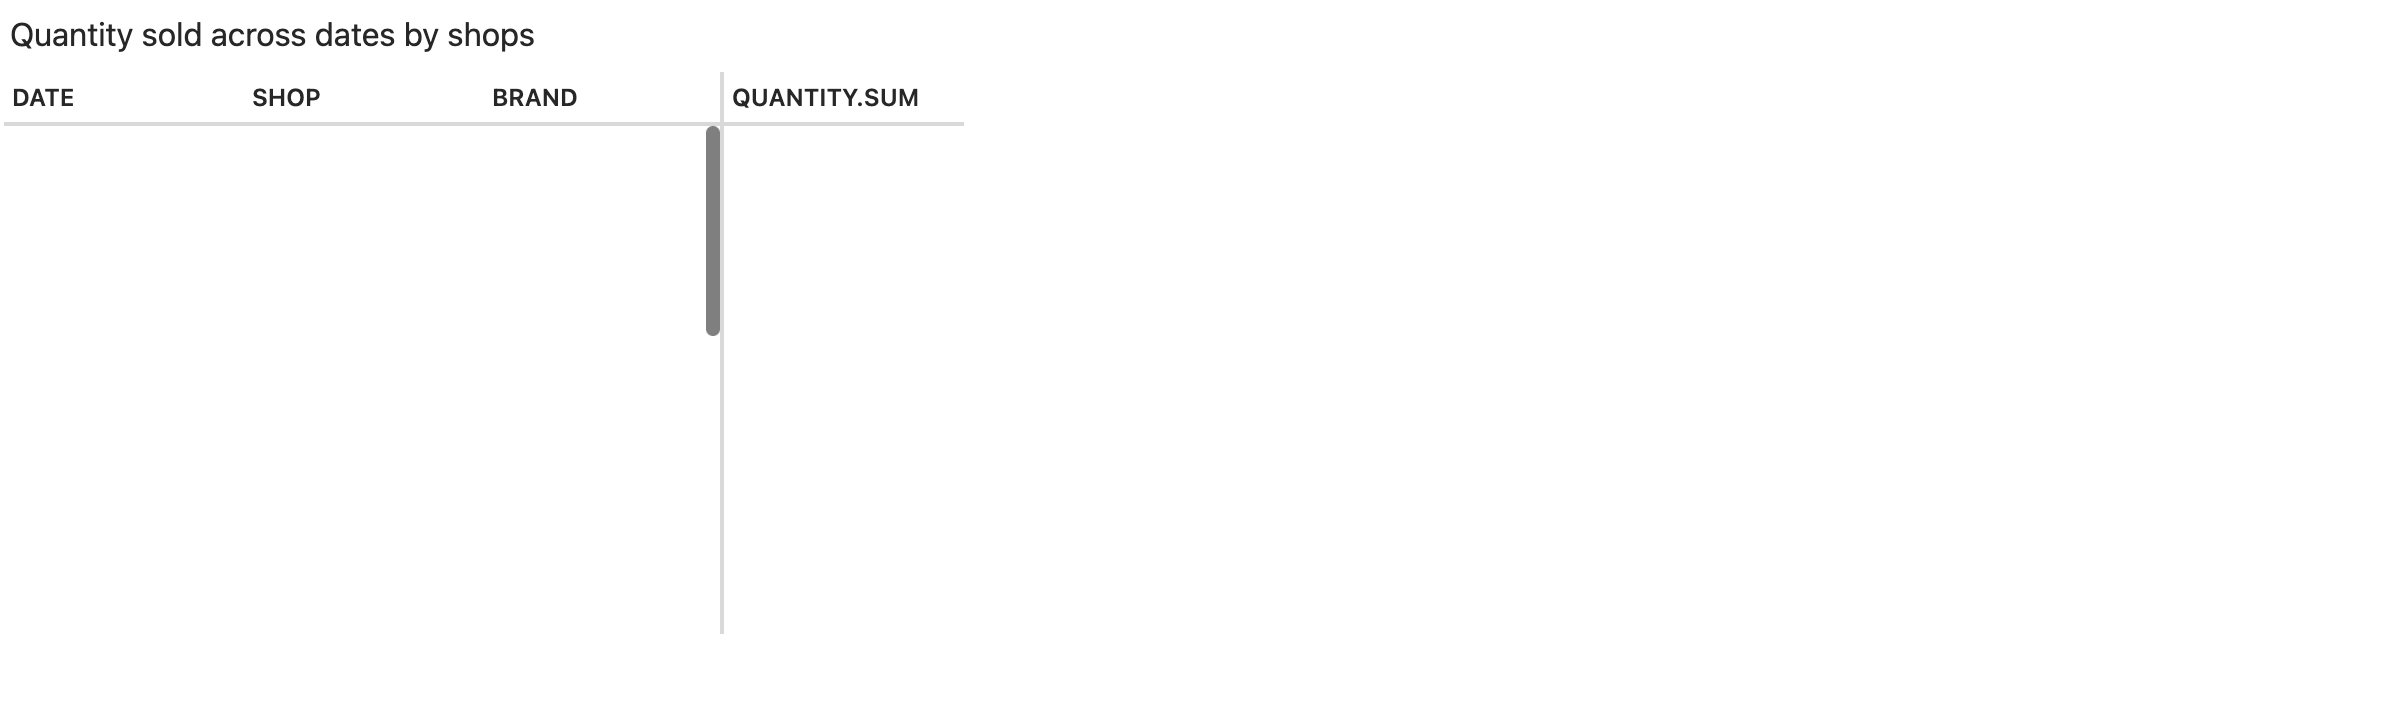

In [15]:
session.widget

### Cube manipulation

We perform hierarchy manipulation, level ordering and measure creations the same way we always do in Atoti.

In [16]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [17]:
h["CATEGORY"] = [l["CATEGORY"], l["SUB_CATEGORY"]]
del h["SUB_CATEGORY"]

In [18]:
h

{('Atoti Product', 'BRAND'): <atoti.hierarchy.Hierarchy object at 0x111212d00>, ('Atoti Sales', 'DATE'): <atoti.hierarchy.Hierarchy object at 0x1112128b0>, ('Atoti Sales', 'SHOP'): <atoti.hierarchy.Hierarchy object at 0x134e801c0>, ('Atoti Product', 'COLOR'): <atoti.hierarchy.Hierarchy object at 0x111212fa0>, ('Atoti Sales', 'PRODUCT'): <atoti.hierarchy.Hierarchy object at 0x134e954f0>, ('Atoti Product', 'SIZE'): <atoti.hierarchy.Hierarchy object at 0x134e95670>, ('Atoti Product', 'CATEGORY'): <atoti.hierarchy.Hierarchy object at 0x134e95580>, ('Atoti Sales', 'SALE_ID'): <atoti.hierarchy.Hierarchy object at 0x134e955b0>}

In [19]:
l["DATE"].order = tt.NaturalOrder(ascending=False)

In [20]:
m["PURCHASE_PRICE.SUM"] = tt.agg.sum(products_table["PURCHASE_PRICE"])
m["PROFIT"] = tt.agg.sum_product(
    m["UNIT_PRICE.SUM"] - m["PURCHASE_PRICE.SUM"],
    m["QUANTITY.SUM"],
    scope=tt.OriginScope(l["SALE_ID"], l["PRODUCT"]),
)

Since we have a join from `sales_table` to `products_table` using the column values of `sales_table.PRODUCT` and `products_table.PRODUCT_ID`, the resultant level is the name of the column from the _from_ table. Therefore, we have the level `PRODUCT` but not `PRODUCT_ID` for our scope in the code snippet above.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
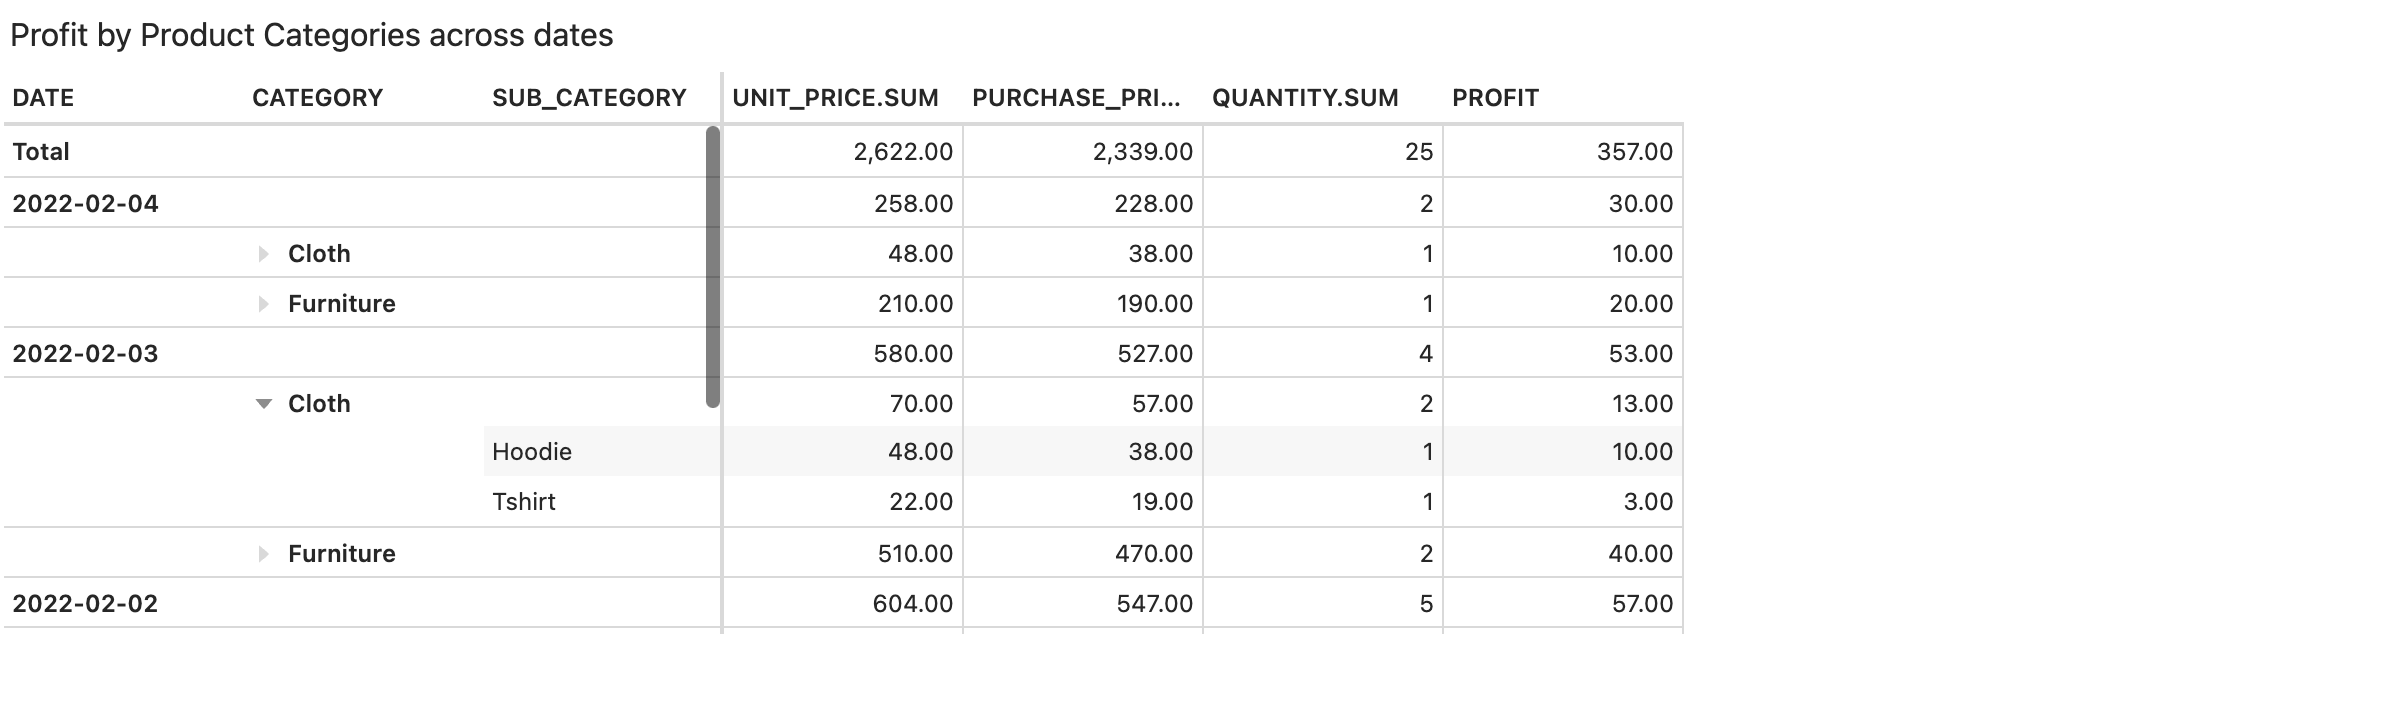

In [21]:
session.widget

## Cost and performance saving with Aggregate Provider

Let's take a quick look at our query performance in the current setup.

In [22]:
%%time

cube.query(
    m["QUANTITY.SUM"], m["PROFIT"], levels=[l["DATE"], l["PRODUCT"], l["SALE_ID"]]
)

CPU times: user 20.6 ms, sys: 6.32 ms, total: 26.9 ms
Wall time: 2.17 s


QUANTITY.SUM PROFIT
DATE       PRODUCT SALE_ID                    
2022-02-04 HOO_5   S0017              1  10.00
           TAB_0   S0000              1  20.00
2022-02-03 HOO_5   S0018              1  10.00
           TAB_0   S0001              1  20.00
           TAB_1   S0004              1  20.00
           TSH_3   S0011              1   3.00
2022-02-02 HOO_5   S0019              1  10.00
           TAB_0   S0002              1  20.00
           TAB_1   S0005              1  20.00
           TSH_3   S0012              1   3.00
           TSH_4   S0014              1   4.00
2022-02-01 BED_2   S0007              1  23.00
           TAB_0   S0003              1  20.00
           TAB_1   S0006              2  40.00
           TSH_3   S0013              1   3.00
           TSH_4   S0015              2   8.00
2022-01-31 BED_2   S0008              1  23.00
                   S0009              1  23.00
                   S0010              3  69.00
           TSH_4   S0016              2   8.00

In [23]:
%%time

cube.query(m["PROFIT"], levels=[l["DATE"], l["SUB_CATEGORY"]])

CPU times: user 16.7 ms, sys: 5.3 ms, total: 22 ms
Wall time: 2.32 s


PROFIT
DATE       CATEGORY  SUB_CATEGORY        
2022-02-04 Cloth     Hoodie         10.00
           Furniture Table          20.00
2022-02-03 Cloth     Hoodie         10.00
                     Tshirt          3.00
           Furniture Table          40.00
2022-02-02 Cloth     Hoodie         10.00
                     Tshirt          7.00
           Furniture Table          40.00
2022-02-01 Cloth     Tshirt         11.00
           Furniture Bed            23.00
                     Table          60.00
2022-01-31 Cloth     Tshirt          8.00
           Furniture Bed           115.00

It takes approximately 3s to return the query.

To speed up our querying, we make use of the [aggregate provider](https://docs.atoti.io/latest/lib/atoti/atoti.aggregate_provider.html#atoti.AggregateProvider) to store intermediate aggregates in memory. If a step of a query uses a subset of the aggregate provider's levels and measures, the provider will speed up the query.  

Since data is cached in memory, we will __not__ access BigQuery when a subset of these are queried.  

In [24]:
cube.aggregate_providers.update(
    {
        "Products provider": tt.AggregateProvider(
            key="bitmap",
            levels=[l["DATE"], l["PRODUCT"], l["SALE_ID"]],
            measures=[m["QUANTITY.SUM"], m["PURCHASE_PRICE.SUM"], m["UNIT_PRICE.SUM"]],
            partitioning="hash16(PRODUCT)",
        )
    }
)

⚠️We can only use store aggregated measures supporting disaggregation can be used in aggregate provider, e.g. `tt.agg.sum` or `tt.agg.mean` on table columns.

`m["PROFIT"]` cannot be used because it is a chained measure resulting from the `sum_product` of a few measures.


In [25]:
%%time

cube.query(m["PROFIT"], levels=[l["DATE"], l["PRODUCT"], l["SALE_ID"]])

CPU times: user 19.8 ms, sys: 5.08 ms, total: 24.9 ms
Wall time: 456 ms


PROFIT
DATE       PRODUCT SALE_ID       
2022-02-04 HOO_5   S0017    10.00
           TAB_0   S0000    20.00
2022-02-03 HOO_5   S0018    10.00
           TAB_0   S0001    20.00
           TAB_1   S0004    20.00
           TSH_3   S0011     3.00
2022-02-02 HOO_5   S0019    10.00
           TAB_0   S0002    20.00
           TAB_1   S0005    20.00
           TSH_3   S0012     3.00
           TSH_4   S0014     4.00
2022-02-01 BED_2   S0007    23.00
           TAB_0   S0003    20.00
           TAB_1   S0006    40.00
           TSH_3   S0013     3.00
           TSH_4   S0015     8.00
2022-01-31 BED_2   S0008    23.00
                   S0009    23.00
                   S0010    69.00
           TSH_4   S0016     8.00

Previously, it took close to 3s to return the query results. Now, it only takes slightly over 100ms to return the results.  

Note that we are querying `PROFIT` and not the measures `m["QUANTITY.SUM"]`, `m["PURCHASE_PRICE.SUM"]` and `m["UNIT_PRICE.SUM"]`. However, `PROFIT` is computed on the fly using the cached data in memory. Therefore, the query speed is improved drastically.

In [26]:
%%time

cube.query(m["PROFIT"], levels=[l["PRODUCT"]])

CPU times: user 8.55 ms, sys: 2.26 ms, total: 10.8 ms
Wall time: 106 ms


,PROFIT
PRODUCT,
BED_2,138.00
HOO_5,30.00
TAB_0,80.00
TAB_1,80.00
TSH_3,9.00
TSH_4,20.00


Querying a subset of the aggregate provider levels also returns the result quickly.  

The below query on a different level will access data from BigQuery and therefore, is limited by the querying speed of the cloud database and its network connectivity.  

In [27]:
%%time

cube.query(m["PROFIT"], levels=[l["DATE"], l["SUB_CATEGORY"]])

CPU times: user 18.7 ms, sys: 5.78 ms, total: 24.5 ms
Wall time: 3.04 s


PROFIT
DATE       CATEGORY  SUB_CATEGORY        
2022-02-04 Cloth     Hoodie         10.00
           Furniture Table          20.00
2022-02-03 Cloth     Hoodie         10.00
                     Tshirt          3.00
           Furniture Table          40.00
2022-02-02 Cloth     Hoodie         10.00
                     Tshirt          7.00
           Furniture Table          40.00
2022-02-01 Cloth     Tshirt         11.00
           Furniture Bed            23.00
                     Table          60.00
2022-01-31 Cloth     Tshirt          8.00
           Furniture Bed           115.00

Before we are done with this example, let's create another aggregate provider with a _slice_ of data using `filter`.  

Let's first capture the timing of the query without the aggregate provider.

In [28]:
%%time

cube.query(
    m["PROFIT"],
    levels=[l["DATE"], l["CATEGORY"], l["SUB_CATEGORY"]],
    filter=(l["DATE"] == "2022-02-04"),
)

CPU times: user 19.4 ms, sys: 6.48 ms, total: 25.9 ms
Wall time: 1.83 s


PROFIT
DATE       CATEGORY  SUB_CATEGORY       
2022-02-04 Cloth     Hoodie        10.00
           Furniture Table         20.00

In [29]:
from datetime import date

current_date = date(2022, 2, 24)

In the event where users are interested in a particular member of level, e.g. the current date or a particular shop, and the amount of querying on this member is huge, then it makes sense to cache them in memory.  

In this case, we apply filter just for the interested member. This helps to control the amount of data held in memory.

In [30]:
cube.aggregate_providers.update(
    {
        "Category provider": tt.AggregateProvider(
            key="bitmap",
            levels=[l["DATE"], l["CATEGORY"], l["SUB_CATEGORY"]],
            measures=[m["QUANTITY.SUM"], m["PURCHASE_PRICE.SUM"], m["UNIT_PRICE.SUM"]],
            filter=(l["DATE"] == current_date),
        )
    }
)

In [31]:
%%time

cube.query(
    m["PROFIT"],
    levels=[l["DATE"], l["CATEGORY"], l["SUB_CATEGORY"]],
    filter=(l["DATE"] == "2022-02-04"),
)

CPU times: user 17.9 ms, sys: 6.13 ms, total: 24 ms
Wall time: 3.05 s


PROFIT
DATE       CATEGORY  SUB_CATEGORY       
2022-02-04 Cloth     Hoodie        10.00
           Furniture Table         20.00

## Balance between Cost and Performance

All in all, Atoti's DirectQuery offers users a way to balance between cost and performance.  
For data that is less queried, it resides on the cloud database and gets queried on-demand.  
For data that is more frequently queried, we can cache it in memory and thereby reduces the number of queries to the cloud database, and improves the performance.  

<img src="https://data.atoti.io/notebooks/direct-query/img/aggregate_cache.png" />  

To find out more, reach out to [ActiveViam](https://activeviam.com/contact-us/?utm_source=github&utm_medium=atoti) for a demonstration.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=intro-direct-query" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>